# Fast Neural Style Transfer

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

from fast_style_transfer_utils import *

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Params

In [2]:
#style = 'VanGogh.png'
style = 'Picasso.png'
#style = 'Kandinsky.png'

calc_ratios = False

### Restructure dataset in convenient way

In [3]:
dataset_path = path/f'{style[:-4]}.csv'

if not os.path.isfile(dataset_path):
    print(f'{style[:-4]} dataset does not exist. Creating it...')
    build_style_dataframe(path, style)
    
df = pd.read_csv(dataset_path)
style_img = PIL.Image.open(df.sample().style_.iloc[0]); (style_img.size + (3,))

(863, 486, 3)

In [4]:
df.head()

,content_,style_,split_
0,/home/ec2-user/SageMaker/data/coco-images/test...,/home/ec2-user/SageMaker/data/styles/Picasso.png,train
1,/home/ec2-user/SageMaker/data/coco-images/test...,/home/ec2-user/SageMaker/data/styles/Picasso.png,train
2,/home/ec2-user/SageMaker/data/coco-images/test...,/home/ec2-user/SageMaker/data/styles/Picasso.png,train
3,/home/ec2-user/SageMaker/data/coco-images/test...,/home/ec2-user/SageMaker/data/styles/Picasso.png,train
4,/home/ec2-user/SageMaker/data/coco-images/test...,/home/ec2-user/SageMaker/data/styles/Picasso.png,train


In [5]:
df.sample().content_.values[0]

'/home/ec2-user/SageMaker/data/coco-images/test2015/COCO_test2015_000000050839.jpg'

### FastStyleTransfer

In [6]:
bs = 4
#sample = 0.5
size = 300
padding = 40

rgb = MakeRGB()
resized = ResizeFixed(size)
tobyte = ToByteTensor()
tofloat = ToFloatTensor()
norm = Normalize(imagenet_stats, padding)
aug = PilRandomDihedral()

tmfs = [rgb, resized, tobyte, tofloat, norm]

train_ds = StyleTransferDataset(dataset_path, train_test='train', transform=tmfs, sample=0.02)
valid_ds = StyleTransferDataset(dataset_path, train_test='valid', transform=tmfs, sample=0.5)

dataloaders = {'train': DataLoader(train_ds, batch_size=bs, shuffle=True),
              'valid': DataLoader(valid_ds, batch_size=bs)}

Valid dataset: 43 items
Item: <class 'tuple'> of 3 <class 'torch.Tensor'>
Item example: 'input':torch.Size([3, 380, 380]),'content':torch.Size([3, 380, 380]),'style':torch.Size([3, 380, 380])
Train dataset: 1626 items
Item: <class 'tuple'> of 3 <class 'torch.Tensor'>
Item example: 'input':torch.Size([3, 380, 380]),'content':torch.Size([3, 380, 380]),'style':torch.Size([3, 380, 380])
train 243
shape of re-center-cropped image: (300, 300, 3)


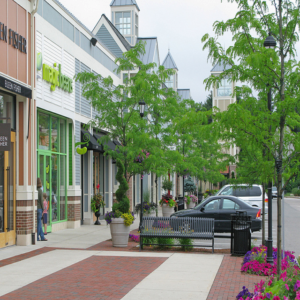

In [7]:
print(valid_ds)
print(train_ds)

datasets = {'train': train_ds, 'valid': valid_ds}
d = random.choice(['train', 'valid'])
i = random.choice(range(len(datasets[d])))
print(d, i)

test_data(dataloaders, datasets, bs, size, padding)
test_deprocess(datasets[d][i], size, padding)

In [8]:
test_hooks(TransformerNet(), dataloaders, bs)
test_losses(TransformerNet(), dataloaders)

shape of input_act:  [torch.Size([4, 64, 380, 380]), torch.Size([4, 128, 190, 190]), torch.Size([4, 256, 95, 95]), torch.Size([4, 512, 47, 47]), torch.Size([4, 512, 23, 23])]
shape of content_act:  [torch.Size([4, 64, 380, 380]), torch.Size([4, 128, 190, 190]), torch.Size([4, 256, 95, 95]), torch.Size([4, 512, 47, 47]), torch.Size([4, 512, 23, 23])]
shape of style_act:  [torch.Size([4, 64, 380, 380]), torch.Size([4, 128, 190, 190]), torch.Size([4, 256, 95, 95]), torch.Size([4, 512, 47, 47]), torch.Size([4, 512, 23, 23])]


In [9]:
# Van Gogh: c2s=7.2e5, c2t=1e-2, tv_weight=4, content_weight=1, style_weight=2e1, vgg=19
# Picasso: c2s=5e5, c2t=1.5e-5, tv_weight=4, content_weight=1, style_weight=1.5e1, vgg=19
# Kandinsky: c2s=4.5e5, c2t=1.5e-5, tv_weight=3, content_weight=1, style_weight=1e1, vgg=19

# Picasso: c2s=5.4e5

In [10]:
if calc_ratios: 
    c2s, c2t = calc_loss_ratios(TransformerNet(), dataset_path, tmfs, size, bs, vgg=19, tv_weight=1)
    print(f'c2s={c2s}, c2t={c2t}')

In [11]:
fst = FastStyleTransfer(dataloaders, *get_model_opt(TransformerNet()), size=size,
                        c2s=8.8e5, c2t=0.02, tv_weight=1e-5, content_weight=1.5, style_weight=10, vgg=19)

In [12]:
fst.train()


Phase: train


(input, content, style) = torch.Size([4, 3, 380, 380]), torch.Size([4, 3, 380, 380]), torch.Size([4, 3, 380, 380])
phase: train, loss: 12.27281768911439

Phase: valid


(input, content, style) = torch.Size([4, 3, 380, 380]), torch.Size([4, 3, 380, 380]), torch.Size([4, 3, 380, 380])
14m 8s



In [13]:
fst.training_done

True

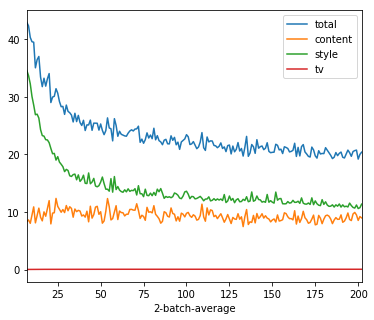

In [14]:
fst.plot_losses('train', group=2)

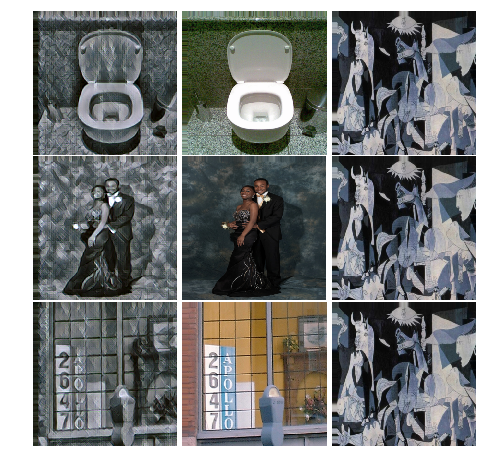

In [15]:
fst.plot_samples('train')

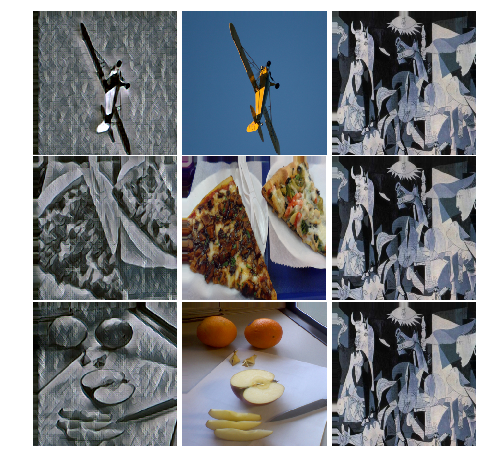

In [16]:
fst.plot_samples('valid')

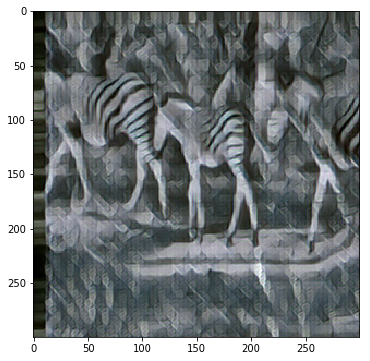

In [28]:
ds = fst.dl['valid'].dataset
idx = random.sample(range(len(ds)), 1)[0]
denorm = DeProcess(imagenet_stats, fst.size, fst.p)
out = denorm(fst.run_st(ds[idx][0]))
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(out); 

In [18]:
#fst.save_model()